In [11]:
import os
import numpy as np
import torch
import pyedflib
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn as nn
import torch.nn.functional as F
from scipy.fft import fft
from collections import Counter

# 설정
sampling_rate = 256
segment_length = 30 * sampling_rate
fft_length = segment_length // 2
label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 1,
    'Sleep stage N3': 2,
    'Sleep stage R': 3
}
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"

In [12]:
def segment_and_fft(signal):
    segments = []
    for start in range(0, len(signal) - segment_length, segment_length):
        segment = signal[start:start+segment_length]
        fft_vals = np.abs(fft(segment))[:fft_length]
        segments.append(fft_vals)
    return np.array(segments)


In [13]:
def load_data_from_sn(sn_list):
    all_segments = []
    all_labels = []
    for sn in sn_list:
        base = f"SN{sn:03d}"
        ecg_path = os.path.join(root_dir, f"{base}.edf")
        label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")
        if not os.path.exists(ecg_path) or not os.path.exists(label_path):
            print(f"❌ 파일 없음: {base}")
            continue
        try:
            ecg_reader = pyedflib.EdfReader(ecg_path)
            ecg_signal = ecg_reader.readSignal(7)
        finally:
            ecg_reader._close()
        try:
            label_reader = pyedflib.EdfReader(label_path)
            annotations = label_reader.readAnnotations()
        finally:
            label_reader._close()
        onsets, durations, labels = annotations
        label_seq = []
        for i in range(len(labels)):
            label_str = labels[i].decode() if isinstance(labels[i], bytes) else labels[i]
            if label_str in label_map:
                label_index = label_map[label_str]
                num_segments = int(durations[i] // 30)
                label_seq.extend([label_index] * num_segments)
        fft_segments = segment_and_fft(ecg_signal)
        max_segments = len(fft_segments)
        usable_len = min(len(label_seq), max_segments)
        all_segments.extend(fft_segments[:usable_len])
        all_labels.extend(label_seq[:usable_len])
    X = torch.tensor(np.expand_dims(np.array(all_segments), axis=1), dtype=torch.float32)
    y = torch.tensor(all_labels, dtype=torch.long)
    return X, y

In [17]:
def load_balanced_data_from_sn(sn_list):
    all_segments = []
    all_labels = []
    for sn in sn_list:
        try:
            X, y = load_data_from_sn([sn])
        except Exception as e:
            print(f"❌ SN{sn:03d} 불러오기 실패: {e}")
            continue
        if len(y) == 0:
            print(f"⚠️ SN{sn:03d}: 라벨 없음 → 건너뜀")
            continue
        y_np = y.numpy()
        X_np = X.numpy()
        label_counts = Counter(y_np)
        if len(label_counts) < 2:
            print(f"⚠️ SN{sn:03d}: 라벨 다양성 부족 → 건너뜀")
            continue
        min_count = min(label_counts.values())
        indices = []
        for label in sorted(label_counts.keys()):
            label_indices = np.where(y_np == label)[0]
            if len(label_indices) < min_count:
                continue
            sampled = np.random.choice(label_indices, min_count, replace=False)
            indices.extend(sampled)
        if not indices:
            print(f"⚠️ SN{sn:03d}: 유효한 샘플 없음 → 건너뜀")
            continue
        np.random.shuffle(indices)
        all_segments.append(X_np[indices])
        all_labels.append(y_np[indices])
        print(f"✅ SN{sn:03d} 처리 완료: 클래스당 {min_count}개")
    if not all_segments:
        raise ValueError("⚠️ 유효한 데이터가 없습니다. SN 목록을 다시 확인하세요.")
    X_all = torch.tensor(np.concatenate(all_segments), dtype=torch.float32)
    y_all = torch.tensor(np.concatenate(all_labels), dtype=torch.long)
    return X_all, y_all

In [19]:
X_train, y_train = load_balanced_data_from_sn(list(range(1, 94)))
X_val, y_val = load_balanced_data_from_sn(list(range(94, 124)))
X_test, y_test = load_data_from_sn(list(range(124, 154)))

✅ SN001 처리 완료: 클래스당 23개
✅ SN002 처리 완료: 클래스당 82개
✅ SN003 처리 완료: 클래스당 150개
✅ SN004 처리 완료: 클래스당 64개
✅ SN005 처리 완료: 클래스당 127개
✅ SN006 처리 완료: 클래스당 65개
✅ SN007 처리 완료: 클래스당 67개
✅ SN008 처리 완료: 클래스당 39개
✅ SN009 처리 완료: 클래스당 91개
✅ SN010 처리 완료: 클래스당 101개
✅ SN011 처리 완료: 클래스당 37개
✅ SN012 처리 완료: 클래스당 184개
✅ SN013 처리 완료: 클래스당 65개
❌ 파일 없음: SN014
⚠️ SN014: 라벨 없음 → 건너뜀
✅ SN015 처리 완료: 클래스당 102개
✅ SN016 처리 완료: 클래스당 24개
✅ SN017 처리 완료: 클래스당 96개
✅ SN018 처리 완료: 클래스당 19개
✅ SN019 처리 완료: 클래스당 72개
✅ SN020 처리 완료: 클래스당 67개
✅ SN021 처리 완료: 클래스당 156개
✅ SN022 처리 완료: 클래스당 115개
✅ SN023 처리 완료: 클래스당 74개
✅ SN024 처리 완료: 클래스당 70개
✅ SN025 처리 완료: 클래스당 106개
✅ SN026 처리 완료: 클래스당 127개
✅ SN027 처리 완료: 클래스당 19개
✅ SN028 처리 완료: 클래스당 136개
✅ SN029 처리 완료: 클래스당 59개
✅ SN030 처리 완료: 클래스당 108개
✅ SN031 처리 완료: 클래스당 74개
✅ SN032 처리 완료: 클래스당 133개
✅ SN033 처리 완료: 클래스당 47개
✅ SN034 처리 완료: 클래스당 75개
✅ SN035 처리 완료: 클래스당 108개
✅ SN036 처리 완료: 클래스당 87개
✅ SN037 처리 완료: 클래스당 65개
✅ SN038 처리 완료: 클래스당 61개
✅ SN039 처리 완료: 클래스당 108개
✅ SN040 처리 완료: 클래스당 62개
✅ SN041 처리 완료

In [20]:
class ECGSleepCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(ECGSleepCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (fft_length // 8), 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [21]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGSleepCNN(num_classes=4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        loss = criterion(outputs, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        _, pred = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()
    train_acc = 100 * correct / total
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            val_total += yb.size(0)
            val_correct += (pred == yb).sum().item()
    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    print(f"📘 Epoch {epoch+1} | Train Loss: {loss_sum:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")



📘 Epoch 1 | Train Loss: 1284.8125 | Train Acc: 31.83% | Val Loss: 1.8164 | Val Acc: 25.22%
📘 Epoch 2 | Train Loss: 1197.7270 | Train Acc: 34.13% | Val Loss: 1.3889 | Val Acc: 32.86%
📘 Epoch 3 | Train Loss: 1185.6194 | Train Acc: 35.67% | Val Loss: 2.9548 | Val Acc: 25.08%
📘 Epoch 4 | Train Loss: 1173.9461 | Train Acc: 37.46% | Val Loss: 1.9160 | Val Acc: 25.71%
📘 Epoch 5 | Train Loss: 1165.0091 | Train Acc: 38.40% | Val Loss: 1.6100 | Val Acc: 26.16%


In [22]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for i in range(0, len(X_test), 32):
        xb = X_test[i:i+32].to(device)
        yb = y_test[i:i+32].to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


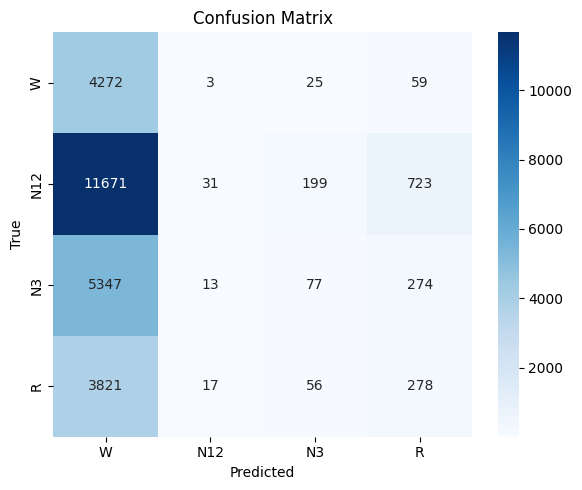

📄 Classification Report:
              precision    recall  f1-score   support

           W       0.17      0.98      0.29      4359
         N12       0.48      0.00      0.00     12624
          N3       0.22      0.01      0.03      5711
           R       0.21      0.07      0.10      4172

    accuracy                           0.17     26866
   macro avg       0.27      0.27      0.11     26866
weighted avg       0.33      0.17      0.07     26866



In [23]:
labels = ['W', 'N12', 'N3', 'R']
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
print("📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))
